## Notebook for Joanito-2022 data processing 
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 18 October 2022

#### Load packages

In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import h5py

In [19]:
import scrublet

In [20]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Setup Cells

In [21]:
%matplotlib inline

In [22]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Upload Data

In [23]:
#Data Upload (csv)
Epithelial_meta = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/Epithelial_metadata.csv', index_col=[1])
Nonepithelial_meta = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/NonEpithelial_metadata.csv', index_col=[1])

In [24]:
#Data Upload (csv)
Patientmeta = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/patient_clinical_information.csv', index_col=[1], encoding='cp1252')

### For anndata==0.8.0 and higher

In [25]:
def read_v3_10x_h5_mod(filename, *, start=None):
    """
    Read hdf5 file from Cell Ranger v3 or later versions.
    """
    with h5py.File(str(filename), 'r') as f:
        try:
            dsets = {}
            sc.readwrite._collect_datasets(dsets, f["matrix"])
            from scipy.sparse import csr_matrix

            M, N = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']
            matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )
            adata = an.AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['name'].astype(str),
                    feature_types=dsets['feature_type'].astype(str),
                    genome=dsets['genome'].astype(str),
                ),
            )
            return adata
        except KeyError:
            raise Exception('File is missing one or more required datasets.')

### For scanpy==1.6.0 and anndata==0.7.4 

In [9]:
def _collect_datasets(dsets: dict, group: h5py.Group):
    for k, v in group.items():
        if isinstance(v, h5py.Dataset):
            dsets[k] = v[()]
        else:
            _collect_datasets(dsets, v)

In [10]:
def read_v3_10x_h5_mod2(filename, *, start=None):
    """
    Read hdf5 file from Cell Ranger v3 or later versions.
    """
    with h5py.File(str(filename), 'r') as f:
        try:
            dsets = {}
            _collect_datasets(dsets, f["matrix"])

            from scipy.sparse import csr_matrix

            M, N = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']
            matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )
            adata = an.AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['name'].astype(str),
                    feature_types=dsets['feature_type'].astype(str),
                    genome=dsets['genome'].astype(str),
                ),
            )
            return adata
        except KeyError:
            raise Exception('File is missing one or more required datasets.')

In [26]:
# Please use read_v3_10x_h5_mod2 for earlier scanpy and anndata versions and read_v3_10x_h5_mod for anndata later than 0.8.0
Epithelian_data = read_v3_10x_h5_mod('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/Epithelial_Count_matrix.h5')

/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_13854/1635666716.py:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = an.AnnData(


In [27]:
# Please use read_v3_10x_h5_mod2 for earlier scanpy and anndata versions and read_v3_10x_h5_mod for anndata later than 0.8.0
Nonepithelian_data = read_v3_10x_h5_mod('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/Joanito_cancer_dataset/NonEpithelial_Count_matrix.h5')

/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_13854/1635666716.py:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = an.AnnData(


#### Preparing anndata file (obs)

In [28]:
#Rename Nonepithelial_meta
Nonepithelial_meta = Nonepithelial_meta.rename(columns={"nCount_RNA": "cell.ID", "msi": "MSS/MSI"})


In [29]:
Nonepithelial_meta

,cell.ID,nFeature_RNA,percent.mt,sample.ID,patient.ID,sample.origin,dataset,cell.type
nCount_RNA,,,,,,,,
29514,CRC16_MUX8563_AAACCTGCAAGCCGCT-1,2577,1.235932,MUX8563,CRC2794,Tumor,CRC-SG1,PlasmaB
3259,CRC16_MUX8563_AAACCTGTCTCGATGA-1,1531,6.171890,MUX8563,CRC2794,Tumor,CRC-SG1,T_NK
71212,CRC16_MUX8563_AAACCTGTCTCTGTCG-1,3083,0.891850,MUX8563,CRC2794,Tumor,CRC-SG1,PlasmaB
3771,CRC16_MUX8563_AAACGGGCAAGTTAAG-1,1686,3.639915,MUX8563,CRC2794,Tumor,CRC-SG1,T_NK
16948,CRC16_MUX8563_AAACGGGCAGTTCATG-1,4304,3.975425,MUX8563,CRC2794,Tumor,CRC-SG1,Fibroblast
...,...,...,...,...,...,...,...,...
10870,KUL5_EXT129_TTTGTCAGTTGGACCC-1,1230,1.356960,EXT129,SC044,Normal,KUL5,PlasmaB
1615,KUL5_EXT129_TTTGTCATCAGCATGT-1,983,9.032534,EXT129,SC044,Normal,KUL5,T_NK
1279,KUL5_EXT129_TTTGTCATCCATGAGT-1,850,7.793522,EXT129,SC044,Normal,KUL5,T_NK


In [30]:
#Merging cells and patients
merged_data_final = pd.concat([Epithelial_meta, Nonepithelial_meta])
merged_data_final = pd.merge(merged_data_final, Patientmeta, 
                   on='patient.ID', how='left')

In [31]:
print(merged_data_final.loc[49150:49160, ])

                                cell.ID  nFeature_RNA  percent.mt sample.ID  \
49150    KUL5_EXT129_CTGTGCTTCGCTTGTC-1          2926   15.401077    EXT129   
49151    KUL5_EXT129_GAAATGAGTTCCTCCA-1          5779   13.561872    EXT129   
49152    KUL5_EXT129_GATCGCGTCTGCTGTC-1          3934   19.530070    EXT129   
49153    KUL5_EXT129_GGAACTTCAGGAATGC-1          5551   11.547377    EXT129   
49154    KUL5_EXT129_TCACAAGGTTTGGGCC-1          3276    9.897333    EXT129   
49155  CRC16_MUX8563_AAACCTGCAAGCCGCT-1          2577    1.235932   MUX8563   
49156  CRC16_MUX8563_AAACCTGTCTCGATGA-1          1531    6.171890   MUX8563   
49157  CRC16_MUX8563_AAACCTGTCTCTGTCG-1          3083    0.891850   MUX8563   
49158  CRC16_MUX8563_AAACGGGCAAGTTAAG-1          1686    3.639915   MUX8563   
49159  CRC16_MUX8563_AAACGGGCAGTTCATG-1          4304    3.975425   MUX8563   
49160  CRC16_MUX8563_AAAGATGAGTTAACGA-1          3080    6.754530   MUX8563   

      patient.ID sample.origin dataset_x   cell.typ

#### Preparing anndata file (var and X)

In [32]:
#Concatenate 2 anndata files (nonepithelial and epithelian)
Joanito_2022 = Nonepithelian_data.concatenate(Epithelian_data)

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [33]:
del Nonepithelian_data, Epithelian_data

#### Merge obs, vars and X

In [34]:
#Create anndata file 
Joanito_2022_anndata = an.AnnData(X=Joanito_2022.X,
                        obs=merged_data_final,
                        var=Joanito_2022.var)

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [35]:
#Chacking final anndata
Joanito_2022_anndata.X

<373058x33287 sparse matrix of type '<class 'numpy.float32'>'
	with 741331835 stored elements in Compressed Sparse Row format>

In [36]:
X_is_raw(Joanito_2022_anndata)

True

In [37]:
Joanito_2022_anndata.raw = Joanito_2022_anndata

#### Rename obs

In [38]:
# Make cell.ID as index in obs
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.set_index('cell.ID')

In [39]:
# Rename columns in obs 
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"sample.ID": "Sample_ID"})
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"patient.ID": "Donor_ID"})
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"cell.type": "Cell Type"})
#Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"sample.origin": "Diagnosis"})
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"Sidedness": "Side"})
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"Site": "Location"})
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"Age at recruitment": "Tumor Stage"})
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"Gender": "Sex"})
Joanito_2022_anndata.obs['Age_group'] = 'Adult'
Joanito_2022_anndata.obs['Study_name'] = 'Joanito, 2022'
Joanito_2022_anndata.obs = Joanito_2022_anndata.obs.rename(columns={"percent.mt": "pct_counts_mito"})
#del Joanito_2022_anndata.obs['nFeature_RNA']

In [40]:
def diagnosis_mapping(label):
    if label.startswith('T1'):
        return 'Colorectal cancer, Stage I'
    elif label.startswith('T2'):
        return 'Colorectal cancer, Stage II'
    elif label.startswith('T3'):
        return 'Colorectal cancer, Stage III'
    elif label.startswith('T4'):
        return 'Colorectal cancer, Stage IV'
    elif label.startswith('mpT3'):
        return 'Colorectal cancer, Stage mpIII'
    elif label.startswith('pT1'):
        return 'Colorectal cancer, Stage pI'
    elif label.startswith('pT2'):
        return 'Colorectal cancer, Stage pII'
    elif label.startswith('pT3'):
        return 'Colorectal cancer, Stage pIII'
    elif label.startswith('pT4'):
        return 'Colorectal cancer, Stage pIV'
    elif label.startswith('ypT3'):
        return 'Colorectal cancer, Stage ypIII'
    else:
        return label  # leave the label unchanged if it doesn't match any of the above
    

Joanito_2022_anndata.obs['Diagnosis'] = Joanito_2022_anndata.obs['Stage TNM']

Joanito_2022_anndata.obs['Diagnosis'] = Joanito_2022_anndata.obs['Diagnosis'].apply(diagnosis_mapping)


In [41]:
Joanito_2022_anndata.obs['Diagnosis'].value_counts()

Colorectal cancer, Stage III      212615
Colorectal cancer, Stage IV       113542
Colorectal cancer, Stage pIII      16645
Colorectal cancer, Stage pIV        8696
Colorectal cancer, Stage II         7062
Colorectal cancer, Stage pI         4224
Colorectal cancer, Stage pII        3159
Colorectal cancer, Stage mpIII      3034
Colorectal cancer, Stage ypIII      2769
Colorectal cancer, Stage I          1312
Name: Diagnosis, dtype: int64

In [42]:
Joanito_2022_anndata

AnnData object with n_obs × n_vars = 373058 × 33287
    obs: 'nFeature_RNA', 'pct_counts_mito', 'Sample_ID', 'Donor_ID', 'sample.origin', 'dataset_x', 'Cell Type', 'iCMS', 'msi', 'dataset_y', 'Sex', 'Tumor Stage', 'MSS/MSI', 'Location', 'Side', 'Group Stage', 'Stage TNM', 'iCMS.transcriptomic', 'iCMS.inferCNV', 'KRAS', 'BRAF', 'TP53', 'APC', 'PIK3CA', 'LymphNode', 'Normal', 'Tumor', 'CMS', 'Age_group', 'Study_name', 'Diagnosis'
    var: 'feature_types', 'genome'

In [43]:
Joanito_2022_anndata.obs['Sex'].replace({'M': 'Male', 
                                        'F': 'Female'}, inplace=True)

In [44]:
Joanito_2022_anndata.obs['Cell Type'].replace({'T_NK': 'T cells', 
                                        'PlasmaB': 'Plasma cells',
                                        'Fibroblast': 'Mesenchymal',
                                        'B': 'B cells'}, inplace=True)

In [45]:
# Calculate quality metrics for cancer dataset
sc.pp.calculate_qc_metrics(Joanito_2022_anndata, inplace=True)

In [46]:
Joanito_2022_anndata.obs

,nFeature_RNA,pct_counts_mito,Sample_ID,Donor_ID,sample.origin,dataset_x,Cell Type,iCMS,msi,dataset_y,...,Study_name,Diagnosis,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
cell.ID,,,,,,,,,,,,,,,,,,,,,
CRC16_MUX8563_AAACGGGGTCGATTGT-1,5099,17.969349,MUX8563,CRC2794,Tumor,CRC-SG1,Epithelial,iCMS2,MSS,CRC-SG1,...,"Joanito, 2022","Colorectal cancer, Stage III",2577,7.854769,29514.0,10.292654,82.221996,84.563258,87.172189,91.044928
CRC16_MUX8563_AAAGATGCAGAAGCAC-1,4759,23.734351,MUX8563,CRC2794,Tumor,CRC-SG1,Epithelial,iCMS2,MSS,CRC-SG1,...,"Joanito, 2022","Colorectal cancer, Stage III",1531,7.334329,3259.0,8.089482,34.581160,42.405646,52.347346,68.364529
CRC16_MUX8563_AAAGCAATCTAACGGT-1,2580,24.403016,MUX8563,CRC2794,Tumor,CRC-SG1,Epithelial,Normal,MSS,CRC-SG1,...,"Joanito, 2022","Colorectal cancer, Stage III",3083,8.033983,71212.0,11.173430,89.725046,91.269730,92.697860,94.829523
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1,2499,11.020450,MUX8563,CRC2794,Tumor,CRC-SG1,Epithelial,iCMS2,MSS,CRC-SG1,...,"Joanito, 2022","Colorectal cancer, Stage III",1686,7.430707,3771.0,8.235361,32.962079,41.500928,51.259613,68.363829
CRC16_MUX8563_ACAGCTATCCGTCATC-1,4937,23.243570,MUX8563,CRC2794,Tumor,CRC-SG1,Epithelial,iCMS2,MSS,CRC-SG1,...,"Joanito, 2022","Colorectal cancer, Stage III",4304,8.367532,16948.0,9.737964,31.602549,39.951617,49.032334,62.030918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KUL5_EXT129_TTTGTCAGTTGGACCC-1,1230,1.356960,EXT129,SC044,Normal,KUL5,Plasma cells,NaN,NaN,KUL5,...,"Joanito, 2022","Colorectal cancer, Stage III",2926,7.981733,8000.0,8.987322,26.037500,35.625000,46.200000,61.250000
KUL5_EXT129_TTTGTCATCAGCATGT-1,983,9.032534,EXT129,SC044,Normal,KUL5,T cells,NaN,NaN,KUL5,...,"Joanito, 2022","Colorectal cancer, Stage III",5779,8.662159,28255.0,10.249061,23.542736,32.503982,42.456202,57.165104
KUL5_EXT129_TTTGTCATCCATGAGT-1,850,7.793522,EXT129,SC044,Normal,KUL5,T cells,NaN,NaN,KUL5,...,"Joanito, 2022","Colorectal cancer, Stage III",3934,8.277666,11016.0,9.307195,23.638344,32.452796,41.485113,55.637255


In [47]:
# Delete unnecessary columns
del Joanito_2022_anndata.obs['log1p_total_counts'], Joanito_2022_anndata.obs['pct_counts_in_top_50_genes'], Joanito_2022_anndata.obs['log1p_n_genes_by_counts']
del Joanito_2022_anndata.obs['pct_counts_in_top_100_genes'], Joanito_2022_anndata.obs['pct_counts_in_top_200_genes'], Joanito_2022_anndata.obs['pct_counts_in_top_500_genes']

In [48]:
# Make a new column "Library_Preparation_Protocol" in Cancer_adata_raw.obs and if Cancer_adata_raw.obs[dataset_x] == 'SMC' then fill it with "10X 3' v2"
# if Cancer_adata_raw.obs[dataset_x] == 'CRC-SG2' then fill it with "10X 3' v3"
# if Cancer_adata_raw.obs[dataset_x] =='KUL3' then fill it with "10X 3' v2"
# if Cancer_adata_raw.obs[dataset_x] =='KUL5' then fill it with "5'"
# if dCancer_adata_raw.obs[dataset_x] == 'CRC-SG1' then fill it with "5'"

# Create a new column "Library_Preparation_Protocol" in Cancer_adata_raw.obs
Joanito_2022_anndata.obs['Library_Preparation_Protocol'] = ""

# Iterate over each row and assign the corresponding protocol value
for idx, row in Joanito_2022_anndata.obs.iterrows():
    dataset_x = row['dataset_x']
    if dataset_x == 'SMC':
        Joanito_2022_anndata.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 3' v2"
    elif dataset_x == 'CRC-SG2':
        Joanito_2022_anndata.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 3' v3"
    elif dataset_x == 'KUL3':
        Joanito_2022_anndata.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 3' v2"
    elif dataset_x == 'KUL5':
        Joanito_2022_anndata.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 5' v1"
    elif dataset_x == 'CRC-SG1':
        Joanito_2022_anndata.obs.at[idx, 'Library_Preparation_Protocol'] = "10x 5' v1"

In [49]:
Joanito_2022_anndata.obs['Library_Preparation_Protocol'].value_counts()

10x 5' v1    249668
10x 3' v2     85295
10x 3' v3     38095
Name: Library_Preparation_Protocol, dtype: int64

In [50]:
#Saving the final anndata file
Joanito_2022_anndata.write('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/anndata/Joanito_raw_anndata_all_cells.h5ad')

### Doublets Identification

In [7]:
Joanito_2022_anndata

AnnData object with n_obs × n_vars = 373058 × 33287
    obs: 'nFeature_RNA', 'pct_counts_mito', 'Sample_ID', 'Donor_ID', 'sample.origin', 'dataset_x', 'Cell Type', 'iCMS', 'msi', 'dataset_y', 'Sex', 'Tumor Stage', 'MSS/MSI', 'Location', 'Side', 'Group Stage', 'Stage TNM', 'iCMS.transcriptomic', 'iCMS.inferCNV', 'KRAS', 'BRAF', 'TP53', 'APC', 'PIK3CA', 'LymphNode', 'Normal', 'Tumor', 'CMS', 'Age_group', 'Study_name', 'Diagnosis', 'n_genes_by_counts', 'total_counts', 'Library_Preparation_Protocol'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [8]:
# Filter only tumor cells
Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs['sample.origin'] == 'Tumor']

In [10]:
scrub = scrublet.Scrublet(Joanito_2022_anndata.X)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 31.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.2%
Elapsed time: 678.8 seconds


/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_13854/889316888.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Joanito_2022_anndata.obs['doublet_scores'], Joanito_2022_anndata.obs['predicted_doublets'] = scrub.scrub_doublets()


(<Figure size 640x240 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

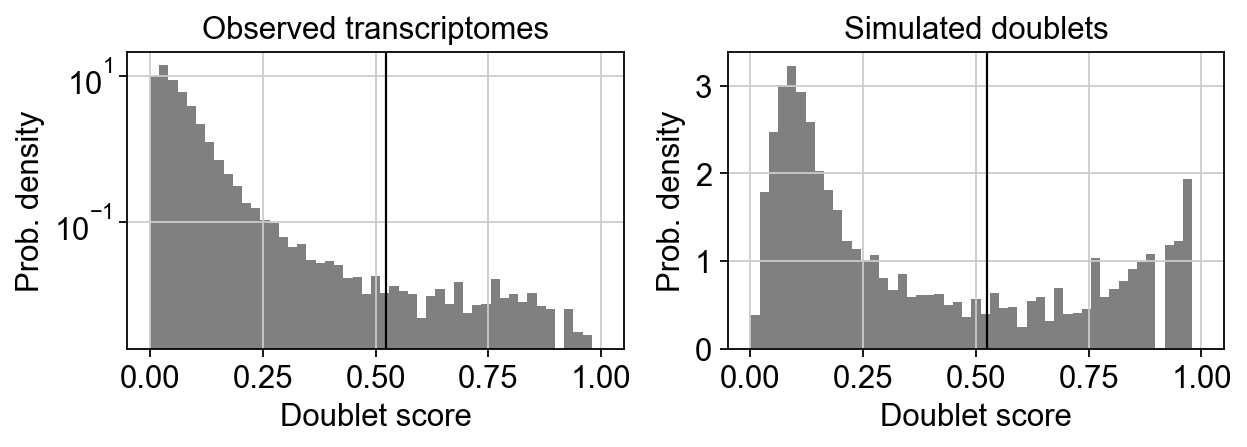

In [11]:
Joanito_2022_anndata.obs['doublet_scores'], Joanito_2022_anndata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [12]:
sum(Joanito_2022_anndata.obs['predicted_doublets'])

656

In [13]:
# add in column with singlet/doublet instead of True/False
Joanito_2022_anndata.obs['doublet_info'] = Joanito_2022_anndata.obs["predicted_doublets"].astype(str)

In [17]:
#Saving the final anndata file
Joanito_2022_anndata.write('/Users/anna.maguza/Desktop/Data/Gut_project/Joanito_cancer/anndata/Joanito_raw_anndata_tumor_cells.h5ad')

### Filter by quality metrics

In [26]:
#Filtering by genes
#Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs.n_genes_by_counts < 4000, :]
#Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs.n_genes_by_counts > 200, :]

#Filtering by counts
#Joanito_2022_anndata = Joanito_2022_anndata[Joanito_2022_anndata.obs.total_counts < 20000, :]